In [1]:
import rasterio
import boto3
import xarray as xr
import numpy as np
import re
from datacube.utils.dask import start_local_dask
from datacube import Datacube
from datacube.utils.geometry import CRS, Geometry, GeoBox
from datacube.testutils.io import native_geobox, native_load
from osgeo import ogr, gdal, osr
import pandas as pd
import matplotlib.pyplot as plt
import os
import fiona
from scipy import ndimage
import dask.array as da
from scipy.spatial.distance import cdist

In [2]:
def native_load_nbart(dss):
    geobox = native_geobox(
            dss[0], basis=list(dss[0].measurements.keys())[0]
        )
    mm = dss[0].type.lookup_measurements(["blue", "green", "red", "nir", "swir1", "swir2", "fmask"])
    tmp_data = Datacube.load_data(Datacube.group_datasets(dss, 'solar_day'),
                    geobox, measurements=mm, dask_chunks={'time': 1})
        
    return tmp_data

In [3]:
def landsat_scene_poly(landsat_shape, region_code):
    with fiona.open(landsat_shape) as all_shapes:
        for s in all_shapes:
            if s['properties'].get('PR') == region_code:
                if len(str(region_code)) < 6:
                    rc = '0' + str(region_code)
                else:
                    rc = str(region_code)    
                return {rc: Geometry(s['geometry'], crs=CRS('EPSG:4326'))}

In [4]:
def detect_cloud_edge(cloud_shadow_mask):
    erosion_struct = ndimage.generate_binary_structure(2, 1)
    tmpe = []
    for c in cloud_shadow_mask:
        cloud_erosion = da.map_blocks(ndimage.binary_erosion, c.data, erosion_struct, dtype=int)
        tmpe += [cloud_erosion ^ c]
    return xr.concat(tmpe, dim="time")  

In [5]:
def erode_dilate_cloud_shadow(func, cloud_shadow_mask, dilation_size):
    erosion_struct = ndimage.generate_binary_structure(2, 1)
    if dilation_size > 0:
        dilation_struct = ndimage.iterate_structure(erosion_struct, dilation_size)
        cloud_shadow_dilated = []
        for c in cloud_shadow_mask:
            cloud_shadow_dilated += [da.map_blocks(func, c.data, dilation_struct, dtype=int)]
        return xr.DataArray(da.stack(cloud_shadow_dilated), dims=['time', 'y', 'x'],
                            coords={'time': cloud_shadow_mask.time, 'y': cloud_shadow_mask.y, 
                                    'x': cloud_shadow_mask.x})
    else:
        return cloud_shadow_mask

In [6]:
def generate_idx(cloud_shadow_mask, dilation_size):
    cloud_shadow_dilated = erode_dilate_cloud_shadow(ndimage.binary_dilation, cloud_shadow, dilation_size)
    tmpe = detect_cloud_edge(cloud_shadow_mask)
    tmpe_dilated = detect_cloud_edge(cloud_shadow_dilated)
    edge_normal_indx = []
    edge_cloud_indx = []
    for c in cloud_shadow_dilated:
        edge_normal_indx += [da.map_blocks(ndimage.distance_transform_edt, c.data, 
                                           return_distances=False, return_indices=True,
                                           new_axis=0, chunks=(2,)+c.data.shape)]
    
    for c in (tmpe | ~cloud_shadow_mask):
        edge_cloud_indx += [da.map_blocks(ndimage.distance_transform_edt, c.data, 
                                          return_distances=False, return_indices=True,
                                          new_axis=0, chunks=(2,)+c.data.shape)]

    edge_normal_indx = xr.DataArray(da.stack(edge_normal_indx), dims=['time', 'idx', 'y', 'x'],
                               coords={'time': cloud_shadow_mask.time, 'idx': [0, 1],
                                       'y': cloud_shadow_mask.y, 'x': cloud_shadow_mask.x})
    edge_cloud_indx = xr.DataArray(da.stack(edge_cloud_indx), dims=['time', 'idx', 'y', 'x'],
                               coords={'time': cloud_shadow_mask.time, 'idx': [0, 1],
                                       'y': cloud_shadow_mask.y, 'x': cloud_shadow_mask.x})
    cloud_ids = edge_cloud_indx.where(tmpe, 0)
    normal_ids = edge_normal_indx.where(tmpe_dilated, 0)
    return cloud_ids, normal_ids

In [7]:
client = start_local_dask(n_workers=1, threads_per_worker=8, memory_limit='60GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/emma.ai@ga.gov.au/proxy/8787/status,
Dashboard: /user/emma.ai@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 8,Total memory: 55.88 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35609,Workers: 1
Dashboard: /user/emma.ai@ga.gov.au/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 55.88 GiB
Comm: tcp://127.0.0.1:45535,Total threads: 8
Dashboard: /user/emma.ai@ga.gov.au/proxy/43565/status,Memory: 55.88 GiB
Nanny: tcp://127.0.0.1:39461,


In [8]:
landsat_shape = "./landsat_au/landsat_au.shp"
grid_shape = "./au-grid.geojson"
au_shape = "./aus_map/cstauscd_r.shp"
dc = Datacube()

In [9]:
sample_pr = 91089

query_poly_dict = landsat_scene_poly(landsat_shape, sample_pr)
for region_code, query_poly in query_poly_dict.items():
    c3_query = {'geopolygon': query_poly}
    c3_query['region_code'] = region_code
    for year in range(2019, 2020):
        c3_query['time'] = (str(year)+'-01-01', str(year+1)+'-01-01')
        c3_ls8_datasets = dc.find_datasets(product='ga_ls8c_ard_3', **c3_query)
        c3_ls8 = native_load_nbart(c3_ls8_datasets)
        
fmask = c3_ls8.fmask
c3_ls8 = c3_ls8.drop("fmask")
data_array = c3_ls8.to_array(dim="bands")
cloud_shadow = ((fmask == 2) | (fmask==3))

In [10]:
cloud_ids, normal_ids = generate_idx(cloud_shadow, 5)

In [55]:
time_slice = 0
# require dask >= 2022.5.1 to make this work, otherwise np.ravel_mutli_index
cloud_idx = da.ravel_multi_index((cloud_ids.data[time_slice][0].flatten(),
                                  cloud_ids.data[time_slice][1].flatten()), 
                                  cloud_ids.data.shape[2:])
cloud_idx = cloud_idx[cloud_idx > 0]
normal_idx = da.ravel_multi_index((normal_ids.data[time_slice][0].flatten(),
                                   normal_ids.data[time_slice][1].flatten()), 
                                   normal_ids.data.shape[2:])
normal_idx = normal_idx[normal_idx > 0]

In [57]:
# no need for this cell if np.ravel_multi_index is used
cloud_idx = cloud_idx.compute()
normal_idx = normal_idx.compute()

In [58]:
cloud_array = []
normal_array = []
for i in range(data_array.shape[0]):
    cloud_array += [data_array.where(data_array != -999)[i, time_slice].data.flatten()[cloud_idx]]
    normal_array += [data_array.where(data_array != -999)[i, time_slice].data.flatten()[normal_idx]]
cloud_array = da.stack(cloud_array)
normal_array = da.stack(normal_array)
normal_array_size = normal_array.shape[1]
cloud_array_size = cloud_array.shape[1]

In [59]:
normal_cos_dis = cdist(cloud_array.T.astype(float)[np.random.uniform(0, cloud_array_size, 10000).astype(int)], 
                       normal_array.T.astype(float)[np.random.uniform(0, normal_array_size, 10000).astype(int)],
                       "cosine")

In [60]:
cloud_cos_dis = cdist(cloud_array.T.astype(float)[np.random.uniform(0, cloud_array_size, 10000).astype(int)], 
                      cloud_array.T.astype(float)[np.random.uniform(0, cloud_array_size, 10000).astype(int)],
                      "cosine")

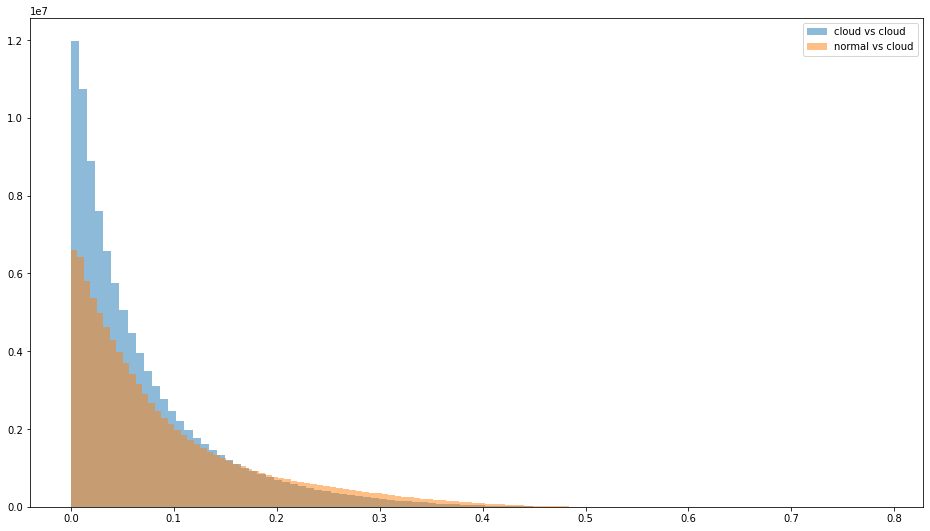

In [61]:
fig = plt.figure(figsize=(16, 9))
plt.hist(cloud_cos_dis.reshape(-1), bins=100, alpha=0.5, label="cloud vs cloud")
plt.hist(normal_cos_dis.reshape(-1), bins=100, alpha=0.5, label="normal vs cloud")
plt.legend(loc="upper right")
plt.show()